##### A script written by Alina Miron based on the tutorial from [TensorFlow on Style Transfer](https://www.tensorflow.org/tutorials/generative/style_transfer) 

Licensed under the Apache License, Version 2.0 (the "License");



# Image style transfer based on neural networks

I always liked to paint, but unfortunately I was never very good at it. In this tutorial we'll look how we could use the power of "artificial intelligence" in order to *paint* an image.

Basically, we will take two images: a target image that we would want to stylise and a reference image. The reference image could be an artwork by a famous painter. We'll blend the two images such that the target image is now painted in the style of the artwork. This is called *style transfer*.

Some parts of the program might seem very complicated. Don't worry if you don't understand how the underlying program works or what each line of code does. The purpose of this tutorial is just to have a high level understanding of how to teach a computer to do *style transfer*.


# Define all the code that we need in order to train our neural network


### Import and configure modules; Define some source code functions what will display images.

In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import time

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Define a function that loads a particular image. All images will be resized to maximum 512 pixels.

In [3]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## Select and visualize the selected images

## Define the neural network for style transfer


Define content and style representations

We'll use a particular type of neural network called a convolutional neural network.



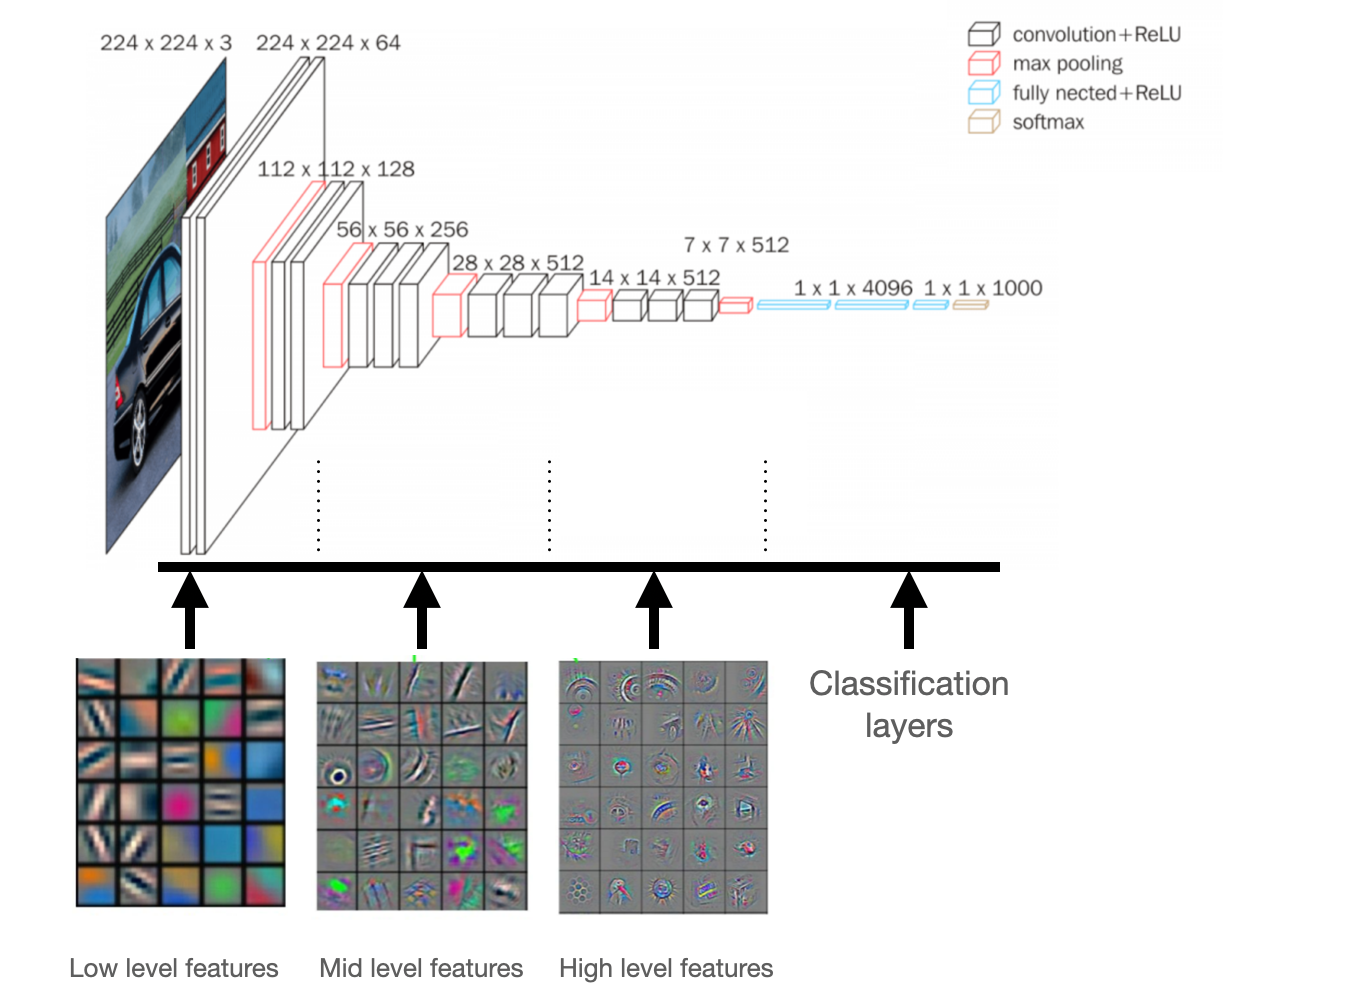



The first few layers from the network represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. 


In this case, we are going to use the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


## Let's see what the network thinks that our image actually is:

In [5]:
def test_network(content_image):
  x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
  x = tf.image.resize(x, (224, 224))
  vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
  prediction_probabilities = vgg(x)

  predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
  [print('The neural network thinks that the image is:', class_name, 'with a probability', prob) for (number, class_name, prob) in predicted_top_5]

Now load a `VGG19` without the classification head, and list the layer names. This is because we are interested in what is called 'the weights of the network', and not the final classification of the image. We'll just use those 'weights' for the style transfer.



## Build the model 


This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [6]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## Calculate style

The content of an image is represented by the values of the intermediate feature maps. We'll calculate something that is called Gram matrix.

In [7]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [8]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

## Run gradient descent

Gradient descent is the algorithm through which a neural network learns.

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.



In [9]:





#Define a helper function that given a float image, will keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

total_variation_weight=30
#@tf.function()
def train_step(image, extractor, opt, style_targets,content_targets, style_weight, content_weight):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

def start_training(content_path, style_path, 
                   number_of_traning_steps, style_weight, content_weight):
  content_image = load_img(content_path)
  style_image = load_img(style_path)
  start = time.time()


  extractor = StyleContentModel(style_layers, content_layers)
  results = extractor(tf.constant(content_image))

  number_of_training_steps_executed = 0

  # Set your style and content target values:
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']
  # Define a `tf.Variable` to contain the image to optimize.
  image = tf.Variable(content_image)
  # Create an optimizer.
  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

  

  #Play with this number to see what is the right number of steps. You could modify this 
  # to be for example 200, 400, 600, 800
  #number_of_traning_steps = 20

  for step in range(number_of_traning_steps):
    train_step(image, extractor, opt, style_targets,content_targets, style_weight, content_weight)

    
   # number_of_training_steps_executed += 1

    print(".", end='')
    # Let's display the image every 5 iterations
    if (step+1) % 5 == 0:
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step in this code run: {}".format(step+1))
      

  end = time.time()
  print("Time training: {:.1f} seconds".format(end-start))
#  print("Total number of training steps that the network was trained for: ", number_of_training_steps_executed)

# Train the computer model

Here we take two images from the internet, a target image and a style image.

Run the tutorial once with these two images, but then try to find your own interesting images. 

Images should be in a .jpg format.

**When you are ready to test with your own images change the file paths here!**

In [10]:
image1_path = "https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg"
content_path = tf.keras.utils.get_file(str(hash(image1_path))+".jpg", image1_path)

image2_path = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg'
style_path = tf.keras.utils.get_file(str(hash(image2_path))+".jpg",image2_path)

483328/478418 [==============================] - 0s 0us/step


Let's display the two images

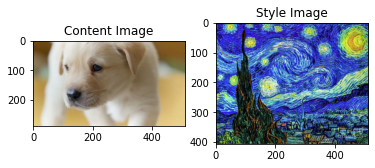

In [11]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

For style transfer we are using a pretrained neural network which we'll refine. Let's see what the pretrained network thinks that our content image is:


In [12]:
test_network(content_image)

40960/35363 [==================================] - 0s 0us/step
The neural network thinks that the image is: golden_retriever with a probability 0.36966413
The neural network thinks that the image is: Labrador_retriever with a probability 0.29010454
The neural network thinks that the image is: Great_Pyrenees with a probability 0.21567088
The neural network thinks that the image is: kuvasz with a probability 0.03486675
The neural network thinks that the image is: Old_English_sheepdog with a probability 0.009803605


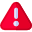
The two variables below style_weight=0.01 and content_weight = 5000 define the balance between the target image and the style image. You can play with these two numbers and see how it affects the resulting image.



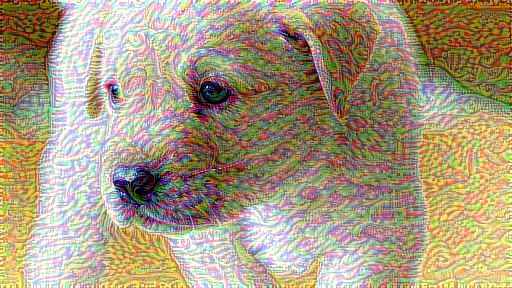

Train step in this code run: 10
Time training: 3.7 seconds


In [13]:
style_weight= 0.01
content_weight= 5000
number_of_iterations = 10
start_training(content_path, style_path,
               number_of_iterations, style_weight, content_weight)

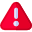Each time you execute the code above, it will train the same network for  number_of_training steps. If you want to re-start the training from 0, you should start re-execute the code from 'Extract style and content' section. Alternatively, you could also make the changes that you want, and then select from the above menu 'Runtime->Restart and run all' 


Finally, save the result by running this code. You could also save the result by right-clicking on the image above and then select 'Save image as'

In [14]:
# file_name = 'stylized-image.png'
# tensor_to_image(image).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download(file_name)